In [1]:
import numpy as np
import sympy as sp
from General import functies as functies
from General import classes as classes
from matplotlib import pyplot as plt

In [5]:
def pH_buffer(pKa, ca, cb):
    return pKa - np.log10(ca/cb)

def nieuw_mengsel(ca, cb, deltaca, deltacb):
    canieuw = ca+deltaca-deltacb
    cbnieuw = cb-deltaca+deltacb
    return canieuw, cbnieuw


C:\Users\User\AppData\Local\Temp\ipykernel_14128\229333990.py:2: RuntimeWarning: divide by zero encountered in divide
  return pKa - np.log10(ca/cb)
C:\Users\User\AppData\Local\Temp\ipykernel_14128\229333990.py:2: RuntimeWarning: divide by zero encountered in log10
  return pKa - np.log10(ca/cb)


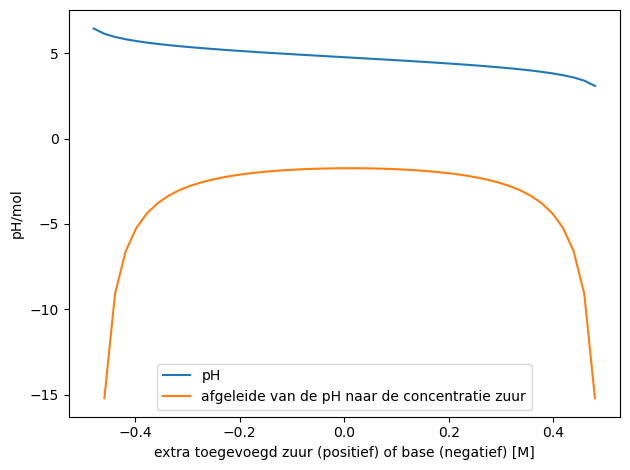

minimum van de afgeleide:
x =  0.0  dy/dx =  -1.7374191621223358


In [18]:
#voorbereidende oefening
cabegin = 0.5 #alles in molair doen
cbbegin = 0.5
pKa = 4.76
extrazuur = np.linspace(-0.5,0.5) #negatief toegevoegd zuur = toegevoegd base
fig, ax = plt.subplots(1,1)
ax.plot(extrazuur, pH_buffer(pKa, *nieuw_mengsel(cabegin, cbbegin, extrazuur, 0)), label = 'pH')
D1 = pH_buffer(pKa, *nieuw_mengsel(cabegin, cbbegin, extrazuur[:-1], 0))
D2 = pH_buffer(pKa, *nieuw_mengsel(cabegin, cbbegin, extrazuur[1:], 0))
afgeleide = (D2-D1)/(extrazuur[1]-extrazuur[0])
ax.plot(extrazuur[1:], afgeleide, label = 'afgeleide van de pH naar de concentratie zuur')
ax.set_xlabel('extra toegevoegd zuur (positief) of base (negatief) [M]')
ax.set_ylabel('pH/mol')
ax.legend()
plt.tight_layout()
plt.show()
print('minimum van de afgeleide:')
print('x = ',(extrazuur[np.argmax(afgeleide)] + extrazuur[1+np.argmax(afgeleide)])/2, ' dy/dx = ', np.max(afgeleide))
#het is duidelijk minimaal rond 0